In [2]:
!pip install wandb -qU

# Библиотеки

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import wandb
from torch.optim.lr_scheduler import StepLR

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

RANDOM_SEED = 1

In [5]:
def read_data(path):
    df = pd.read_csv(path, sep=';')
    df.replace("-", np.nan, inplace=True)
    df.replace("\\", np.nan, inplace=True)
    df.replace("--", np.nan, inplace=True)

    df.dropna(inplace=True)
    for c in df.columns:
        df[c] = df[c].apply(lambda x: float(x))

    if "BHP" in df.columns:
        df = df[df["BHP"] >= 0.0]
    df.reset_index(drop=True, inplace=True)

    return df

def split_groups(n_group, series):
    classes = dict(zip([i for i in range(n_group)], [[] for i in range(n_group)]))
    max_ = series.max()
    min_ = series.min()

    div = (max_ - min_) / n_group

    for i, x in enumerate(series):

        new_x = x - min_

        cl = int(new_x // div)
        assert cl < n_group
        classes[cl].append((x, i))
    return classes

def avg_feature(class_dict, name, size):
    class_mean = {}
    for i in range(len(class_dict)):
        z = [k for k, _ in class_dict[i]]
        class_mean[i] = np.mean(z)

    df = {name: [0] * size}

    for k, v in class_dict.items():
        for i in v:
            df[name][i[1]] = class_mean[k]

    return pd.DataFrame(df)

def normalize_data(X):
    normalized_X = (X-X.mean()) / (X.std() + 1e-8)
    return normalized_X

# Читаем данные

In [6]:
df = read_data('train.csv')
df

,THP,WCT,GOR,PUMP,LIQ,BHP
0,1.935320,0.274556,30.115301,38.259932,1.911736,81.60
1,1.088830,0.400938,30.141835,38.704510,37.934106,72.04
2,1.419345,0.348165,30.322438,38.661283,56.510475,66.05
3,1.350603,0.954636,30.327780,38.292798,74.555543,61.45
4,1.309956,0.285772,30.957152,38.132067,93.317508,58.80
...,...,...,...,...,...,...
33619,97.000000,1.880224,250.364370,60.938765,277.313384,212.78
33620,97.000000,1.786033,250.172131,60.564574,295.424946,229.57
33621,97.000000,1.883817,250.391623,60.606323,313.457465,314.78
33622,97.000000,1.526007,250.120282,60.999503,331.799192,315.17


# Чистка

In [7]:
df = df[df["WCT"] < 10]
df = df[df["PUMP"] > 30]
df.reset_index(inplace=True, drop=True)
df["WCT"] /= 2
df

,THP,WCT,GOR,PUMP,LIQ,BHP
0,1.935320,0.137278,30.115301,38.259932,1.911736,81.60
1,1.088830,0.200469,30.141835,38.704510,37.934106,72.04
2,1.419345,0.174083,30.322438,38.661283,56.510475,66.05
3,1.350603,0.477318,30.327780,38.292798,74.555543,61.45
4,1.309956,0.142886,30.957152,38.132067,93.317508,58.80
...,...,...,...,...,...,...
33617,97.000000,0.940112,250.364370,60.938765,277.313384,212.78
33618,97.000000,0.893016,250.172131,60.564574,295.424946,229.57
33619,97.000000,0.941909,250.391623,60.606323,313.457465,314.78
33620,97.000000,0.763004,250.120282,60.999503,331.799192,315.17


## Explore columns

### BHP

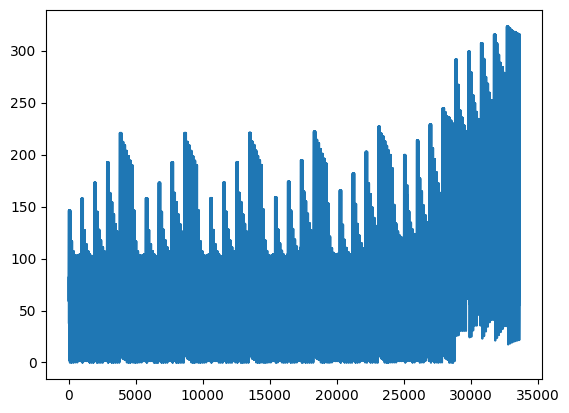

323.28 0.0


In [10]:
col = "BHP"

plt.plot(range(len(df)), df[col])
plt.show()

print(max(df[col]), min(df[col]))

### GOR

KeyError: 'Mean_GOR'

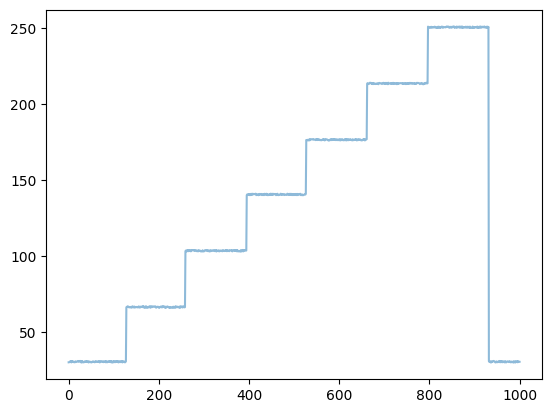

In [11]:
# plt.plot(range(len(df)), df["GOR"])
# plt.show()
plt.plot(range(1001), df.loc[:1000, "GOR"], alpha=0.5)
plt.plot(range(1001), df.loc[:1000, "Mean_GOR"], alpha=0.5)
plt.show()

print(max(df["GOR"]), min(df["GOR"]))

In [12]:
gc = split_groups(n_group=7, series=df["GOR"])


In [13]:
df_mean_pump = avg_feature(class_dict = gc, name = "Mean_GOR", size = len(df))
df_mean_pump

,Mean_GOR
0,30.496186
1,30.496186
2,30.496186
3,30.496186
4,30.496186
...,...
33617,250.503330
33618,250.503330
33619,250.503330
33620,250.503330


In [ ]:
# df = df.join(df_mean_pump)
# df

In [ ]:
# df.drop(columns=["GOR"], inplace=True)
# df

### WCT

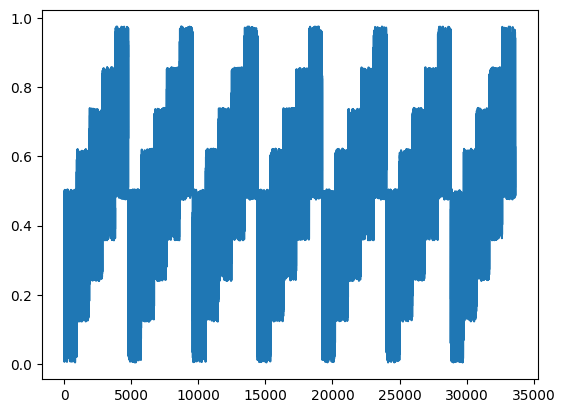

0.9749900745 0.005059201


In [14]:
plt.plot(range(len(df)), df["WCT"])
plt.show()

print(max(df["WCT"]), min(df["WCT"]))

In [15]:
df[df["WCT"] > 10]

,THP,WCT,GOR,PUMP,LIQ,BHP


In [16]:
# df = df[df["WCT"] < 10]
# df

### THP

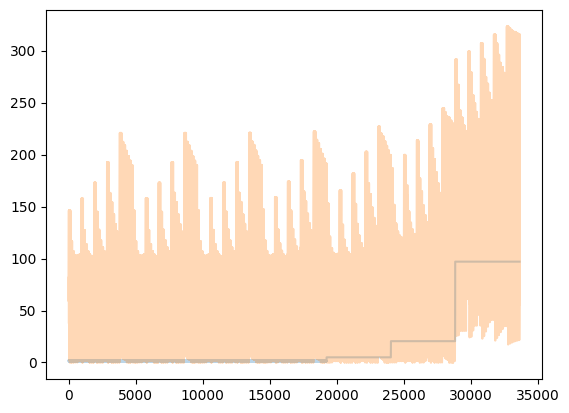

97.0 1.000069249


In [17]:
col = "THP"

plt.plot(range(len(df)), df[col], alpha=0.3)
plt.plot(range(len(df)), df["BHP"], alpha=0.3)
plt.show()

print(max(df[col]), min(df[col]))

### PUMP

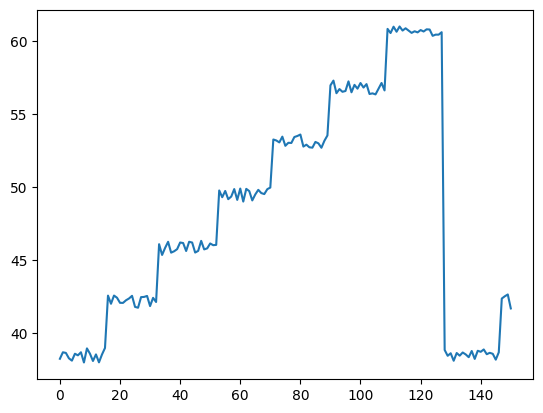

60.99994029 38.00006261


In [18]:
col = "PUMP"

plt.plot(range(151), df.loc[:150, col], alpha=1)

# plt.plot(range(len(df)), df["BHP"], alpha=0.5)
plt.show()

print(max(df[col]), min(df[col]))

In [19]:
# df = df[df["PUMP"] > 30]
# df

<Axes: ylabel='Frequency'>

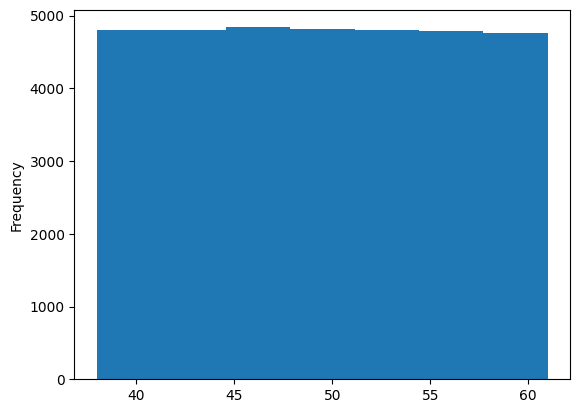

In [20]:
df["PUMP"].plot(kind="hist", bins = 7)

In [22]:
col = "PUMP"

plt.plot(range(26), df_val.loc[:25, col], alpha=1)

# plt.plot(range(len(df)), df["BHP"], alpha=0.5)
plt.show()

# print(max(df[col]), min(df[col]))

NameError: name 'df_val' is not defined

In [23]:
pc = split_groups(n_group=7, series=df["PUMP"])
pc

{0: [(38.25993183, 0),
  (38.70450997, 1),
  (38.66128256, 2),
  (38.29279824, 3),
  (38.13206714, 4),
  (38.60496711, 5),
  (38.49603502, 6),
  (38.70596035, 7),
  (38.00741695, 8),
  (38.97064611, 9),
  (38.60857233, 10),
  (38.11035623, 11),
  (38.55921424, 12),
  (38.01577506, 13),
  (38.55092334, 14),
  (38.99796853, 15),
  (38.86338002, 128),
  (38.46370318, 129),
  (38.63803034, 130),
  (38.12571165, 131),
  (38.65363617, 132),
  (38.47401596, 133),
  (38.69034252, 134),
  (38.55915378, 135),
  (38.3685255, 136),
  (38.79295552, 137),
  (38.25165643, 138),
  (38.80763052, 139),
  (38.73904209, 140),
  (38.89828227, 141),
  (38.57340058, 142),
  (38.66791444, 143),
  (38.6004442, 144),
  (38.19999939, 145),
  (38.7024363, 146),
  (38.29786569, 259),
  (38.35085035, 260),
  (38.37527015, 261),
  (38.0060652, 262),
  (38.24928889, 263),
  (38.19530297, 264),
  (38.68142867, 265),
  (38.39982363, 266),
  (38.57456404, 267),
  (38.10104891, 268),
  (38.07398314, 269),
  (38.88503978,

In [24]:
df_mean_pump = avg_feature(class_dict = pc, name = "Mean_PUMP", size = len(df))
df_mean_pump

,Mean_PUMP
0,38.500229
1,38.500229
2,38.500229
3,38.500229
4,38.500229
...,...
33617,60.504402
33618,60.504402
33619,60.504402
33620,60.504402


In [ ]:
# df = df.join(df_mean_pump)
# df

KeyError: 'Mean_PUMP'

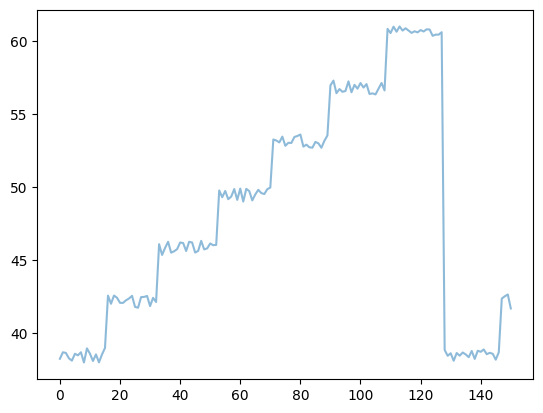

In [25]:
col = "PUMP"

plt.plot(range(151), df.loc[:150, col], alpha=0.5)
plt.plot(range(151), df.loc[:150, "Mean_PUMP"], alpha=0.5)

# plt.plot(range(len(df)), df["BHP"], alpha=0.5)
plt.show()

print(max(df[col]), min(df[col]))

In [ ]:
# df.drop(columns=["PUMP"], inplace=True)
# df

### LIQ

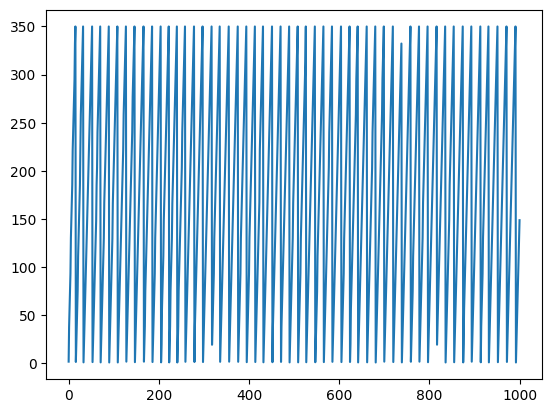

350.0 1.000880796


In [26]:
col = "LIQ"

plt.plot(range(1001), df.loc[:1000, col], alpha=1)
# plt.plot(range(len(df)), df["BHP"], alpha=0.5)
plt.show()

print(max(df[col]), min(df[col]))

<Axes: >

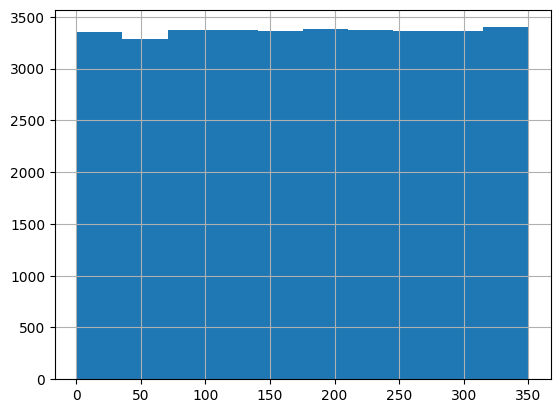

In [27]:
df["LIQ"].hist()

# Normalize

In [28]:
df

,THP,WCT,GOR,PUMP,LIQ,BHP
0,1.935320,0.137278,30.115301,38.259932,1.911736,81.60
1,1.088830,0.200469,30.141835,38.704510,37.934106,72.04
2,1.419345,0.174083,30.322438,38.661283,56.510475,66.05
3,1.350603,0.477318,30.327780,38.292798,74.555543,61.45
4,1.309956,0.142886,30.957152,38.132067,93.317508,58.80
...,...,...,...,...,...,...
33617,97.000000,0.940112,250.364370,60.938765,277.313384,212.78
33618,97.000000,0.893016,250.172131,60.564574,295.424946,229.57
33619,97.000000,0.941909,250.391623,60.606323,313.457465,314.78
33620,97.000000,0.763004,250.120282,60.999503,331.799192,315.17


In [29]:
train_mean = df.iloc[:, :-1].mean()
train_std = df.iloc[:, :-1].std()

print(train_mean, train_std)

THP      18.353686
WCT       0.490173
GOR     140.175580
PUMP     49.483382
LIQ     176.481505
dtype: float64 THP      32.755515
WCT       0.220384
GOR      73.430535
PUMP      7.327617
LIQ     105.816345
dtype: float64


In [30]:
df.iloc[:, :-1] = normalize_data(df.iloc[:, :-1])
df

,THP,WCT,GOR,PUMP,LIQ,BHP
0,-0.501240,-1.601278,-1.498835,-1.531664,-1.649743,81.60
1,-0.527082,-1.314546,-1.498474,-1.470993,-1.309319,72.04
2,-0.516992,-1.434274,-1.496014,-1.476892,-1.133767,66.05
3,-0.519091,-0.058331,-1.495942,-1.527179,-0.963235,61.45
4,-0.520332,-1.575831,-1.487371,-1.549114,-0.785928,58.80
...,...,...,...,...,...,...
33617,2.401010,2.041617,1.500585,1.563316,0.952895,212.78
33618,2.401010,1.827919,1.497967,1.512250,1.124055,229.57
33619,2.401010,2.049770,1.500957,1.517948,1.294469,314.78
33620,2.401010,1.237980,1.497261,1.571605,1.467804,315.17


# Обучаем модель

In [31]:

if 'BHP' in df.columns:
    y = df[['BHP']]
    df.drop(columns=['BHP'], inplace=True)
X = df

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26897, 5) (3363, 5) (26897, 1) (3363, 1)


In [32]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation, dropout_rate):
        super(MLP, self).__init__()
        self.layers = []
        for size in hidden_sizes:
            self.layers.append(nn.Linear(input_size, size))
            input_size = size
            self.layers.append(nn.BatchNorm1d(size))
            self.layers.append(activation)
            if dropout_rate:
                self.layers.append(nn.Dropout(dropout_rate))

        self.layers.append(nn.Linear(input_size, 1))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)


In [33]:
exp1_parameters = {
    'lr': [0.01],
    'scheduler_step': 5,
    'scheduler_gamma': 0.1,
    'hidden_sizes': [
        # [10, 6, 6, 10],
        # [6, 10, 10, 6],
        # [6, 15, 15, 6]
        # [5, 6, 6, 5],
        # [5, 7, 7, 5],
        # [5, 10, 10, 5],
        # [10, 10, 10, 10],
        # [5, 20, 20, 5],
        [50, 50, 50, 50]

    ],
    'activations': [
        # nn.Sigmoid(),
        # nn.ReLU(),
        # nn.Tanh(),
        nn.LeakyReLU(),
        # nn.SELU(),
        # nn.ELU(),
    ]
}

BATCH_SIZE = 256
EPOCHS = 30
device = torch.device("cpu")

In [34]:
train_dataset = TensorDataset(torch.from_numpy(X_train.values.astype(np.float32)), torch.from_numpy(y_train.values.astype(np.float32)))
val_dataset = TensorDataset(torch.from_numpy(X_val.values.astype(np.float32)), torch.from_numpy(y_val.values.astype(np.float32)))
test_dataset = TensorDataset(torch.from_numpy(X_test.values.astype(np.float32)), torch.from_numpy(y_test.values.astype(np.float32)))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [35]:
def train_step(model, optimizer, criterion, train_dataloader, use_wandb = True):
    model.train()
    losses = []
    mses = []
    iters = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        y_pred = y_pred.detach().cpu()
        y_batch = y_batch.detach().cpu()
        mse = mean_squared_error(y_pred, y_batch)

        if iters % 100 == 0 and use_wandb:
            wandb.log({"training_loss": loss.item()})

        losses.append(loss.item())
        mses.append(mse)

        iters += 1

    mean_mse = np.mean(mses)
    if use_wandb:
      wandb.log({"training_mean_mse": mean_mse})
    return losses, mean_mse


def eval_step(model, criterion, val_dataloader, use_wandb = True):
    model.eval()
    losses = []
    mses = []
    iters = 0
    for X_batch, y_batch in val_dataloader:
        with torch.no_grad():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            y_pred = y_pred.detach().cpu()
            y_batch = y_batch.detach().cpu()
            mse = mean_squared_error(y_pred, y_batch)
            losses.append(loss.item())
            mses.append(mse)
            if iters % 100 == 0 and use_wandb:
                wandb.log({"val_loss": loss.item()})

            iters += 1

    mean_mse = np.mean(mses)
    if use_wandb:
      wandb.log({"val_mean_mse": mean_mse})
    return np.mean(losses), mean_mse

def test_step(model, test_dataloader):
    model.eval()
    mses = []
    for X_batch, y_batch in test_dataloader:
        with torch.no_grad():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            y_pred = y_pred.detach().cpu()
            y_batch = y_batch.detach().cpu()
            mse = mean_squared_error(y_pred, y_batch)
            mses.append(mse)
    return np.mean(mses)


def train(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, scheduler, epochs, use_wandb = True):
    for epoch in tqdm(range(epochs), "Epochs"):
        lr = next(iter(optimizer.param_groups))["lr"]
        if use_wandb:
          wandb.log({"LR": lr})
        train_losses, train_mse = train_step(model, optimizer, criterion, train_dataloader, use_wandb)
        val_mean_loss, val_mse = eval_step(model, criterion, val_dataloader, use_wandb)
        scheduler.step()

    test_mse = test_step(model, test_dataloader)
    if use_wandb:
      wandb.log({"test_mse": test_mse})
    else:
      print(test_mse)

    return train_losses, train_mse, val_mean_loss, val_mse, test_mse



def run_exp(exp_parameters, train_dataloader, val_dataloader, test_dataloader, use_wandb=True):

    for lr in exp_parameters['lr']:
        for activation in exp_parameters['activations']:
            for hidden_sizes in exp_parameters['hidden_sizes']:
                if use_wandb:
                  wandb.init(
                      # set the wandb project where this run will be logged
                      project="sirius_energy",

                      # track hyperparameters and run metadata
                      config={
                        "learning_rate": lr,
                        "hidden_sizes": ",".join(list(map(str, hidden_sizes))),
                        "activation": activation.__class__.__name__,
                        "scheduler_step": exp_parameters['scheduler_step'],
                        "scheduler_gamma": exp_parameters['scheduler_gamma']
                      }
                  )
                seed_everything(42)
                model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, activation=activation, dropout_rate=None)
                model = model.to(device)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.2)
                scheduler = StepLR(optimizer, step_size=exp_parameters['scheduler_step'], gamma=exp_parameters['scheduler_gamma'])
                train(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, scheduler, epochs=EPOCHS, use_wandb=use_wandb)


step = 5, gamma=0.3

In [36]:
run_exp(exp1_parameters, train_dataloader, val_dataloader, test_dataloader)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epochs: 100%|██████████| 30/30 [01:45<00:00,  3.53s/it]


# Генерируем файл  ответов

In [37]:
df

,THP,WCT,GOR,PUMP,LIQ
0,-0.501240,-1.601278,-1.498835,-1.531664,-1.649743
1,-0.527082,-1.314546,-1.498474,-1.470993,-1.309319
2,-0.516992,-1.434274,-1.496014,-1.476892,-1.133767
3,-0.519091,-0.058331,-1.495942,-1.527179,-0.963235
4,-0.520332,-1.575831,-1.487371,-1.549114,-0.785928
...,...,...,...,...,...
33617,2.401010,2.041617,1.500585,1.563316,0.952895
33618,2.401010,1.827919,1.497967,1.512250,1.124055
33619,2.401010,2.049770,1.500957,1.517948,1.294469
33620,2.401010,1.237980,1.497261,1.571605,1.467804


In [39]:
df_val = read_data('val.csv')
df_val

,THP,WCT,GOR,PUMP,LIQ
0,7.0,0.1,45.0,39.0,10.0
1,7.0,0.1,45.0,39.0,100.0
2,7.0,0.1,45.0,39.0,155.0
3,7.0,0.1,45.0,39.0,210.0
4,7.0,0.1,45.0,39.0,265.0
...,...,...,...,...,...
3120,50.0,1.0,200.0,55.6,10.0
3121,50.0,1.0,200.0,55.6,100.0
3122,50.0,1.0,200.0,55.6,155.0
3123,50.0,1.0,200.0,55.6,210.0


In [40]:
df_val = (df_val - train_mean) / (train_std + 1e-8)
df_val

,THP,WCT,GOR,PUMP,LIQ
0,-0.346619,-1.770428,-1.296131,-1.430667,-1.573306
1,-0.346619,-1.770428,-1.296131,-1.430667,-0.722776
2,-0.346619,-1.770428,-1.296131,-1.430667,-0.203007
3,-0.346619,-1.770428,-1.296131,-1.430667,0.316761
4,-0.346619,-1.770428,-1.296131,-1.430667,0.836530
...,...,...,...,...,...
3120,0.966137,2.313362,0.814708,0.834735,-1.573306
3121,0.966137,2.313362,0.814708,0.834735,-0.722776
3122,0.966137,2.313362,0.814708,0.834735,-0.203007
3123,0.966137,2.313362,0.814708,0.834735,0.316761


### Обучение лучшей модели

In [41]:
seed_everything(RANDOM_SEED)

lr = 0.01
hidden_sizes = [50, 50, 50, 50]
activation = nn.ReLU()


model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, activation=activation, dropout_rate=None)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.2)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
_ = train(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, scheduler, epochs=EPOCHS, use_wandb=False)

Epochs: 100%|██████████| 30/30 [01:43<00:00,  3.44s/it]


311.15976


### Предсказание val.csv

In [42]:
x_final = torch.from_numpy(df_val.values.astype(np.float32))
x_final

tensor([[-0.3466, -1.7704, -1.2961, -1.4307, -1.5733],
        [-0.3466, -1.7704, -1.2961, -1.4307, -0.7228],
        [-0.3466, -1.7704, -1.2961, -1.4307, -0.2030],
        ...,
        [ 0.9661,  2.3134,  0.8147,  0.8347, -0.2030],
        [ 0.9661,  2.3134,  0.8147,  0.8347,  0.3168],
        [ 0.9661,  2.3134,  0.8147,  0.8347,  0.8365]])

In [43]:
with torch.no_grad():
    preds = model(x_final.to(device))

preds = preds.detach().cpu().numpy()
preds

array([[ 89.639046],
       [ 60.383995],
       [ 90.73011 ],
       ...,
       [ 51.755405],
       [114.15665 ],
       [202.67177 ]], dtype=float32)

In [44]:
# Сохранения файла с ответами
pd.DataFrame(preds, columns=["BHP"]).to_csv('predictions.csv', sep=';', index=False, encoding="utf-8")